In [ ]:
import pandas as pd
import re
import sys
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
df = pd.read_csv('Labelled Yelp Dataset.csv',encoding='latin1')
df.shape

(359052, 6)

In [ ]:
df.head()

,User_id,Product_id,Rating,Date,Review,Label
0,923,0,3,12/8/2014,The food at snack is a selection of popular Gr...,-1
1,924,0,3,5/16/2013,This little place in Soho is wonderful. I had ...,-1
2,925,0,4,7/1/2013,ordered lunch for 15 from Snack last Friday. Ã...,-1
3,926,0,4,7/28/2011,This is a beautiful quaint little restaurant o...,-1
4,927,0,4,11/1/2010,Snack is great place for a ÃÂ casual sit down...,-1


## EDA

In [ ]:
statistics_of_data = []
for col in df[['User_id','Product_id','Rating','Date','Label']]:
    statistics_of_data.append((col,
                             len(df[col]),
                             100-df[col].isnull().sum()*100/df.shape[0],
                             df[col].nunique(),
                             df[col].value_counts().idxmax()
                             ))
stats_df = pd.DataFrame(statistics_of_data, columns=['Column Name', '# of Records', '% populated', 'Unique Values', 'Most Common Field Value'])
stats_df

,Column Name,# of Records,% populated,Unique Values,Most Common Field Value
0,User_id,359052,100.0,160225,3504
1,Product_id,359052,100.0,923,247
2,Rating,359052,100.0,5,5
3,Date,359052,100.0,3417,1/5/2015
4,Label,359052,100.0,2,1


In [ ]:
### for reviews text
statistics_of_data = []
for col in df[['Review']]:
    statistics_of_data.append((col,
                             len(df[col]),
                             100-df[col].isnull().sum()*100/df.shape[0],
                             df[col].nunique()
                             ))
stats_df = pd.DataFrame(statistics_of_data, columns=['Column Name', '# of Records', '% populated', 'Unique Values'])
stats_df

,Column Name,# of Records,% populated,Unique Values
0,Review,359052,100.0,358156


In [ ]:
#### We can see that these data is 100% populated and we do not need to deal with missing values

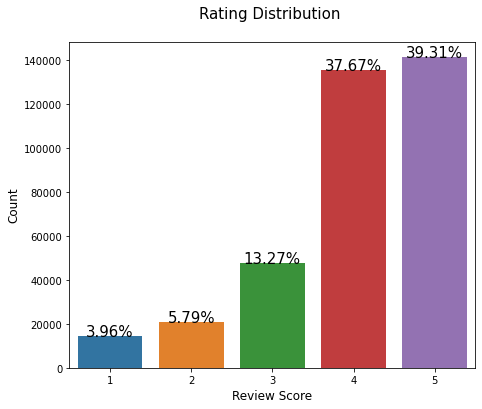

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(121)
g = sns.countplot(x='Rating', data=df)
total = len(df)
g.set_title("Rating Distribution \n", fontsize=15)
g.set_xlabel("Review Score", fontsize=12)
g.set_ylabel('Count', fontsize=12)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
plt.show()

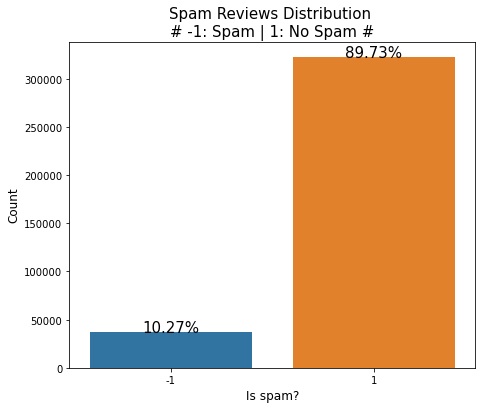

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(121)
g = sns.countplot(x='Label', data=df)
total = len(df)
g.set_title("Spam Reviews Distribution \n# -1: Spam | 1: No Spam #", fontsize=15)
g.set_xlabel("Is spam?", fontsize=12)
g.set_ylabel('Count', fontsize=12)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
plt.show()

In [ ]:
df['Date'] = pd.to_datetime(df.Date)

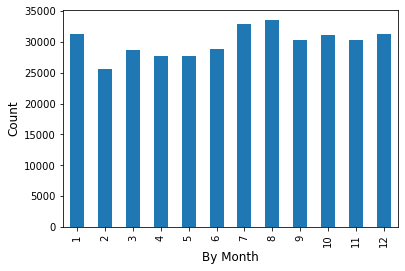

<Figure size 1440x720 with 0 Axes>

In [ ]:
#By month
df2 = df['Date'].groupby(df.Date.dt.month).agg('count')
g = df2.plot(kind='bar')
g.set_xlabel("By Month", fontsize=12)
g.set_ylabel('Count', fontsize=12)
plt.figure(figsize=(20,10))
plt.show()

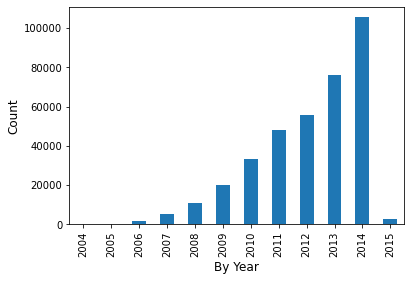

<Figure size 1440x720 with 0 Axes>

In [ ]:
#By year
df2 = df['Date'].groupby(df.Date.dt.year).agg('count')
g = df2.plot(kind='bar')
g.set_xlabel("By Year", fontsize=12)
g.set_ylabel('Count', fontsize=12)
plt.figure(figsize=(20,10))
plt.show()

## Remove Stopwords and Regex and Lemmentazation

In [ ]:
from textacy.preprocessing.replace import urls, hashtags, numbers, emails, emojis, currency_symbols
from textacy.preprocessing.normalize import quotation_marks, bullet_points
from textacy.preprocessing.remove import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from collections import Counter

In [ ]:
df['Review'] = df['Review'].str.lower()

In [ ]:
# remove all urls, hashtags,numbers,currency_symbols, emojis, emails and punctuation
df["Review_cleaned"] = df['Review'].\
  apply(urls).\
  apply(hashtags).\
  apply(numbers).\
  apply(currency_symbols).\
  apply(emojis).\
  apply(emails).\
  apply(punctuation)

In [ ]:
# remove stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))
df['Review_no_stopwords'] = df['Review_cleaned'].apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word not in (stopwords)]))

In [ ]:
#Apply word lemmentazation
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [ ]:
df['Review_Lemma'] = df['Review_no_stopwords'].apply(lemmatize_sentence)

In [ ]:
#compression_opts = dict(method='zip',
                        #archive_name='cleaned_data.csv')  
#df.to_csv('yelp.zip', index=False,
          #compression=compression_opts)  

In [ ]:
df1 = pd.read_csv('cleaned_data.csv',encoding='latin1')
df1.head()

,User_id,Product_id,Rating,Date,Review,Label,Review_cleaned,Review_no_stopwords,Review_Lemma
0,923,0,3,2014-12-08,the food at snack is a selection of popular gr...,-1,the food at snack is a selection of popular gr...,food snack selection popular greek dishes appe...,food snack selection popular greek dish appeti...
1,924,0,3,2013-05-16,this little place in soho is wonderful. i had ...,-1,this little place in soho is wonderful i had ...,little place soho wonderful lamb sandwich glas...,little place soho wonderful lamb sandwich glas...
2,925,0,4,2013-07-01,ordered lunch for 15 from snack last friday. Ã...,-1,ordered lunch for NUMBER from snack last fri...,ordered lunch NUMBER snack last friday Ã£ÂÃ¢ ...,order lunch NUMBER snack last friday Ã£ÂÃ¢ ti...
3,926,0,4,2011-07-28,this is a beautiful quaint little restaurant o...,-1,this is a beautiful quaint little restaurant o...,beautiful quaint little restaurant pretty stre...,beautiful quaint little restaurant pretty stre...
4,927,0,4,2010-11-01,snack is great place for a Ã£ÂÃ¢Â casual sit ...,-1,snack is great place for a Ã£ÂÃ¢Â casual sit ...,snack great place Ã£ÂÃ¢ casual sit lunch espe...,snack great place Ã£ÂÃ¢ casual sit lunch espe...


## Spam/No Spam Classification

In [ ]:
# label as 0 or 1: 1 stands spam,0 stans for nonspam
df1['Label'] = np.where(df1['Label'] == -1,1,0)
df1

,User_id,Product_id,Rating,Date,Review,Label,Review_cleaned,Review_no_stopwords,Review_Lemma
0,923,0,3,2014-12-08,the food at snack is a selection of popular gr...,1,the food at snack is a selection of popular gr...,food snack selection popular greek dishes appe...,food snack selection popular greek dish appeti...
1,924,0,3,2013-05-16,this little place in soho is wonderful. i had ...,1,this little place in soho is wonderful i had ...,little place soho wonderful lamb sandwich glas...,little place soho wonderful lamb sandwich glas...
2,925,0,4,2013-07-01,ordered lunch for 15 from snack last friday. Ã...,1,ordered lunch for NUMBER from snack last fri...,ordered lunch NUMBER snack last friday Ã£ÂÃ¢ ...,order lunch NUMBER snack last friday Ã£ÂÃ¢ ti...
3,926,0,4,2011-07-28,this is a beautiful quaint little restaurant o...,1,this is a beautiful quaint little restaurant o...,beautiful quaint little restaurant pretty stre...,beautiful quaint little restaurant pretty stre...
4,927,0,4,2010-11-01,snack is great place for a Ã£ÂÃ¢Â casual sit ...,1,snack is great place for a Ã£ÂÃ¢Â casual sit ...,snack great place Ã£ÂÃ¢ casual sit lunch espe...,snack great place Ã£ÂÃ¢ casual sit lunch espe...
...,...,...,...,...,...,...,...,...,...
359047,161146,349,5,2014-02-06,"i'm very spoiled with pizza. really, i have tr...",0,i m very spoiled with pizza really i have tr...,spoiled pizza really tried lucali di fara john...,spoil pizza really tried lucali di fara john b...
359048,116424,349,5,2014-01-31,can't say enough good things about this place....,0,can t say enough good things about this place ...,say enough good things place stopped last nigh...,say enough good thing place stop last night NU...
359049,161147,349,5,2014-01-30,"had a great dinner here- fantastic pizza, the ...",0,had a great dinner here fantastic pizza the ...,great dinner fantastic pizza pizza dessert bit...,great dinner fantastic pizza pizza dessert bit...
359050,97930,349,5,2014-01-25,"great foods and great drinks, they have even p...",0,great foods and great drinks they have even p...,great foods great drinks even pairing wines pi...,great food great drink even pair wine pizza gr...


In [ ]:
import re
df1['Review_Lemma'] = df1['Review_Lemma'].str.replace(r'[Ã£Â\WÃ¢]', ' ')
df1.head(5)

<ipython-input-142-7c24575f9db7>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['Review_Lemma'] = df1['Review_Lemma'].str.replace(r'[Ã£Â\WÃ¢]', ' ')


,User_id,Product_id,Rating,Date,Review,Label,Review_cleaned,Review_no_stopwords,Review_Lemma
0,923,0,3,2014-12-08,the food at snack is a selection of popular gr...,1,the food at snack is a selection of popular gr...,food snack selection popular greek dishes appe...,food snack selection popular greek dish appeti...
1,924,0,3,2013-05-16,this little place in soho is wonderful. i had ...,1,this little place in soho is wonderful i had ...,little place soho wonderful lamb sandwich glas...,little soho wonderful lamb sandwich glass wi...
2,925,0,4,2013-07-01,ordered lunch for 15 from snack last friday. Ã...,1,ordered lunch for NUMBER from snack last fri...,ordered lunch NUMBER snack last friday Ã£ÂÃ¢ ...,order lunch NUMBER snack last friday ti...
3,926,0,4,2011-07-28,this is a beautiful quaint little restaurant o...,1,this is a beautiful quaint little restaurant o...,beautiful quaint little restaurant pretty stre...,beautiful quaint little restaurant pretty stre...
4,927,0,4,2010-11-01,snack is great place for a Ã£ÂÃ¢Â casual sit ...,1,snack is great place for a Ã£ÂÃ¢Â casual sit ...,snack great place Ã£ÂÃ¢ casual sit lunch espe...,snack great casual sit lunch especial...
...,...,...,...,...,...,...,...,...,...
359047,161146,349,5,2014-02-06,"i'm very spoiled with pizza. really, i have tr...",0,i m very spoiled with pizza really i have tr...,spoiled pizza really tried lucali di fara john...,spoil pizza really tried lucali di fara john b...
359048,116424,349,5,2014-01-31,can't say enough good things about this place....,0,can t say enough good things about this place ...,say enough good things place stopped last nigh...,say enough good thing stop last night NUMBER...
359049,161147,349,5,2014-01-30,"had a great dinner here- fantastic pizza, the ...",0,had a great dinner here fantastic pizza the ...,great dinner fantastic pizza pizza dessert bit...,great dinner fantastic pizza pizza dessert bit...
359050,97930,349,5,2014-01-25,"great foods and great drinks, they have even p...",0,great foods and great drinks they have even p...,great foods great drinks even pairing wines pi...,great food great drink even pair wine pizza gr...


### Word Vectorizer

In [ ]:
#split the dataset 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# delete null values in Review_lemma  
df1['Review_Lemma'].isnull().sum()

0

In [ ]:
df1 = df1.dropna()
df1['Review_Lemma'].isnull().sum()

0

In [ ]:
num_samples = 10000
spams = df1.loc[df1['Label'] == 1].iloc[:num_samples]
hams = df1.loc[df1['Label'] == 0].iloc[:num_samples]
docs = pd.concat([spams,hams])
docs.head()

,User_id,Product_id,Rating,Date,Review,Label,Review_cleaned,Review_no_stopwords,Review_Lemma
0,923,0,3,2014-12-08,the food at snack is a selection of popular gr...,1,the food at snack is a selection of popular gr...,food snack selection popular greek dishes appe...,food snack selection popular greek dish appeti...
1,924,0,3,2013-05-16,this little place in soho is wonderful. i had ...,1,this little place in soho is wonderful i had ...,little place soho wonderful lamb sandwich glas...,little soho wonderful lamb sandwich glass wi...
2,925,0,4,2013-07-01,ordered lunch for 15 from snack last friday. Ã...,1,ordered lunch for NUMBER from snack last fri...,ordered lunch NUMBER snack last friday Ã£ÂÃ¢ ...,order lunch NUMBER snack last friday ti...
3,926,0,4,2011-07-28,this is a beautiful quaint little restaurant o...,1,this is a beautiful quaint little restaurant o...,beautiful quaint little restaurant pretty stre...,beautiful quaint little restaurant pretty stre...
4,927,0,4,2010-11-01,snack is great place for a Ã£ÂÃ¢Â casual sit ...,1,snack is great place for a Ã£ÂÃ¢Â casual sit ...,snack great place Ã£ÂÃ¢ casual sit lunch espe...,snack great casual sit lunch especial...


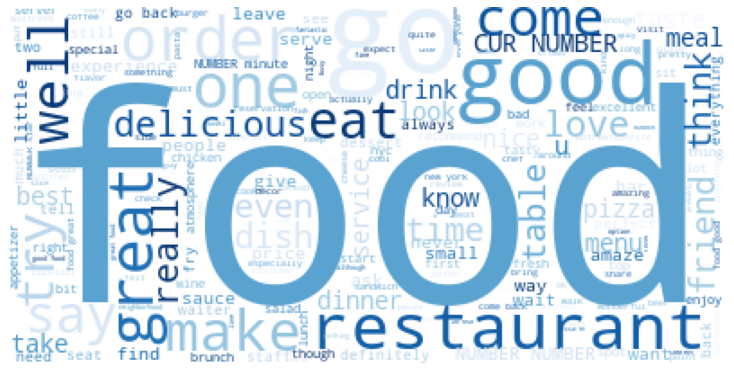

In [ ]:
from wordcloud import WordCloud
list_spams = spams['Review_Lemma'].tolist()
new_spams = "".join(list_spams)
spam_wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="Blues").generate(new_spams)
plt.figure( figsize=(10,8))
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()
# Most common word in spams are place, restaurant,great,order,good, etc.

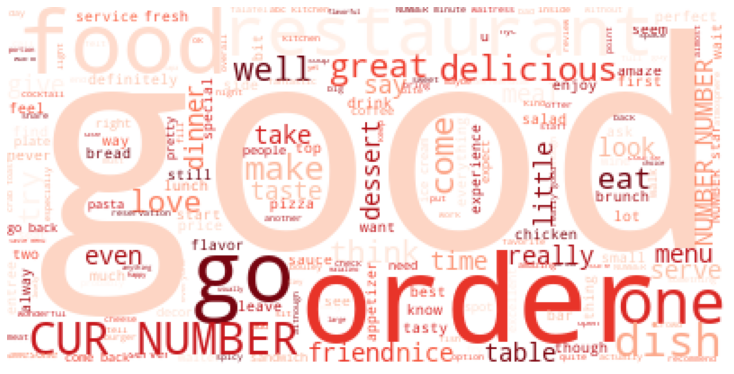

In [ ]:
list_hams = hams['Review_Lemma'].tolist()
new_hams = "".join(list_hams)
ham_wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="Reds").generate(new_hams)
plt.figure( figsize=(10,8))
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()
#Most common word in hams are place, order good, etc. 

In [ ]:
# vectorizer1 = CountVectorizer(ngram_range = (2,2),
#                              stop_words = 'english',
#                              binary = True,
#                              max_df = 2)
# X1 = vectorizer1.fit_transform(docs['Review_Lemma'])
# X1.shape

(20000, 402422)

In [ ]:
vectorizer2 = TfidfVectorizer(stop_words = 'english',
                             ngram_range = (2,2),
                             #max_df = 2,
                             binary = True)
X2 = vectorizer2.fit_transform(docs['Review_Lemma'])
X2.shape

(20000, 455403)

In [ ]:
X = X2
y = docs['Label']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

## Classification Models

In [ ]:
# Logistic regression,random forest, naive bayes, decision tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [ ]:
mnb = MultinomialNB(alpha=0.2)
lrc = LogisticRegression()
rfc = RandomForestClassifier(n_estimators=250, random_state=50,max_depth = 30)

In [ ]:
models = {'Naive Bayes':mnb,'Logistic Regression':lrc,'Random Forest':rfc}

In [ ]:
accuracy = {}
accuracy2 = {}
for key, values in models.items():
    model = values.fit(X_train,y_train)
    predicted = values.predict(X_test)
    accuracy.update({key:accuracy_score(y_test,predicted)})
    accuracy2.update({key:model.score(X_train,y_train)})
print(f'accuracy:{accuracy2}\n')
print(f'predicted accuracy:{accuracy}')

accuracy:{'Naive Bayes': 0.9949285714285714, 'Logistic Regression': 0.9779285714285715, 'Random Forest': 0.7641428571428571}

predicted accuracy:{'Naive Bayes': 0.7238333333333333, 'Logistic Regression': 0.7226666666666667, 'Random Forest': 0.6761666666666667}


## Classification model: GloVe and RNN

In [3]:
import pandas as pd
from typing import List, Tuple

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Labelled Yelp Dataset.csv to Labelled Yelp Dataset.csv


In [4]:
import io
df_yelp = pd.read_csv(io.BytesIO(uploaded['Labelled Yelp Dataset.csv']))

In [5]:
df_yelp.head()

,User_id,Product_id,Rating,Date,Review,Label
0,923,0,3,12/8/2014,The food at snack is a selection of popular Gr...,-1
1,924,0,3,5/16/2013,This little place in Soho is wonderful. I had ...,-1
2,925,0,4,7/1/2013,ordered lunch for 15 from Snack last Friday. Â...,-1
3,926,0,4,7/28/2011,This is a beautiful quaint little restaurant o...,-1
4,927,0,4,11/1/2010,Snack is great place for a Â casual sit down l...,-1


In [6]:
docs=df_yelp['Review'].tolist()
labels=df_yelp['Label'].to_numpy()

#### Load in Spacy medium model

In [7]:
import spacy
nlp = spacy.load("en_core_web_sm", disable = ['ner', 'tagger', 'parser'])
from scipy.spatial.distance import cosine

#### Use Spacy to tokenize and remove stopwords

In [8]:
stopwords_removed_docs = list(
    map(lambda doc: " ".join([token.text for token in nlp(doc) if not token.is_stop]), docs))

#### Tokenize text

In [9]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(stopwords_removed_docs)

#### set max sequence length

In [10]:
MAX_SEQUENCE_LENGTH = 150

In [11]:
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

from tensorflow.keras.preprocessing.sequence import pad_sequences

# integer encode the documents
encoded_docs = integer_encode_documents(stopwords_removed_docs, tokenizer)
print(f"Encoded docs: {encoded_docs[:5]}")
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print(f"Padded docs: {padded_docs[:5]}")

Encoded docs: [[4, 1063, 183, 661, 749, 70, 222, 2208, 5, 749, 55, 2767, 346, 1090, 64, 39, 127, 220, 124], [21, 6, 1430, 231, 202, 91, 314, 61, 107, 2198, 38, 595, 1430, 57, 21, 1, 666, 4, 7, 335, 437, 1891, 9], [15, 77, 274, 1063, 453, 3, 2, 10, 1220, 4, 7, 3, 2, 541, 402, 1312, 77, 226, 161, 41], [415, 1183, 21, 13, 31, 246, 3, 2, 1, 1430, 3375, 7, 6, 339, 230, 425, 180, 202, 91, 22, 116, 736, 2238, 78, 616, 675, 202, 20, 11, 99, 3327, 68, 91, 7, 221, 3, 2, 89, 6], [1063, 7, 6, 3, 2, 558, 214, 77, 169, 236, 1014, 82, 3, 2, 1731, 13, 4506, 4, 293, 456, 3, 2, 1, 100, 3989, 536, 355, 886, 55, 1099, 257, 3, 2, 749, 170, 128, 1, 774, 208, 393, 4432, 80, 780, 23, 885, 73, 37, 3, 2, 38, 186, 3743, 921, 13, 1063, 3623, 638, 476, 5, 44, 1551, 597, 109, 845, 485]]
Padded docs: [[   4 1063  183  661  749   70  222 2208    5  749   55 2767  346 1090
    64   39  127  220  124    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
   

#### encode label

In [12]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = to_categorical(encoder.fit_transform(labels))

In [13]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

#### test/train split

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.2)

#### import Keras

In [15]:
from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding

In [16]:
VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

#### Load in GloVe

In [17]:
!wget https://dso-560-nlp-text-analytics.s3.amazonaws.com/glove6b100dtxt.zip
!unzip glove6b100dtxt.zip 

--2022-05-06 01:24:03--  https://dso-560-nlp-text-analytics.s3.amazonaws.com/glove6b100dtxt.zip
Resolving dso-560-nlp-text-analytics.s3.amazonaws.com (dso-560-nlp-text-analytics.s3.amazonaws.com)... 52.217.235.41
Connecting to dso-560-nlp-text-analytics.s3.amazonaws.com (dso-560-nlp-text-analytics.s3.amazonaws.com)|52.217.235.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137847651 (131M) [application/zip]
Saving to: ‘glove6b100dtxt.zip’

glove6b100dtxt.zip  100%[===================>] 131.46M  47.5MB/s    in 2.8s    

2022-05-06 01:24:06 (47.5 MB/s) - ‘glove6b100dtxt.zip’ saved [137847651/137847651]

Archive:  glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


In [18]:
from typing import Dict
def load_glove_vectors()-> Dict:
    embeddings_index = {}
    with open('glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


#### Load in embeddings

In [19]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

#### define model

In [20]:
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking
# define model
def make_binary_classification_rnn_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=32, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

#### compile model

In [21]:
model = make_lstm_classification_model()
model_rnn = make_binary_classification_rnn_model()
print(model)
print(model_rnn)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 100)          14327800  
                                                                 
 masking (Masking)           (None, 150, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 14,345,386
Trainable params: 17,586
Non-trainable params: 14,327,800
_________________________________________________________________
Model: "sequential_1"
_________________

#### fit the model - lstm

In [22]:
# fit the model
history = model.fit(X_train, y_train,validation_split = 0.1, epochs=3, verbose=1)

Epoch 1/3
8079/8079 [==============================] - 1400s 173ms/step - loss: 0.3100 - accuracy: 0.8974 - val_loss: 0.3088 - val_accuracy: 0.8962
Epoch 2/3
8079/8079 [==============================] - 1383s 171ms/step - loss: 0.3031 - accuracy: 0.8976 - val_loss: 0.3051 - val_accuracy: 0.8962
Epoch 3/3
8079/8079 [==============================] - 1376s 170ms/step - loss: 0.2997 - accuracy: 0.8976 - val_loss: 0.3061 - val_accuracy: 0.8962


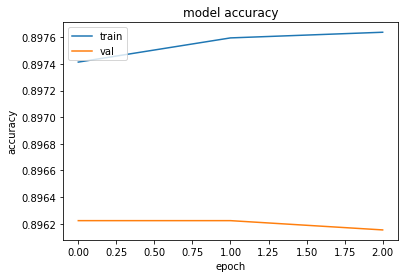

In [23]:
import keras
from matplotlib import pyplot as plt

def plot_fit_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_fit_history(history)

#### evaluate the model - lstm

In [24]:
# baseline accuracy
y_test.mean()

0.5

In [25]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

2245/2245 [==============================] - 81s 36ms/step - loss: 0.3049 - accuracy: 0.8974
Accuracy: 89.741129


#### fit the model - rnn

In [26]:
# fit the model
history = model_rnn.fit(X_train, y_train,validation_split = 0.2, epochs=3, verbose=1)

Epoch 1/3
7181/7181 [==============================] - 390s 54ms/step - loss: 0.3261 - accuracy: 0.8973 - val_loss: 0.3220 - val_accuracy: 0.8962
Epoch 2/3
7181/7181 [==============================] - 391s 54ms/step - loss: 0.3246 - accuracy: 0.8975 - val_loss: 0.3333 - val_accuracy: 0.8962
Epoch 3/3
7181/7181 [==============================] - 387s 54ms/step - loss: 0.3238 - accuracy: 0.8975 - val_loss: 0.3212 - val_accuracy: 0.8962


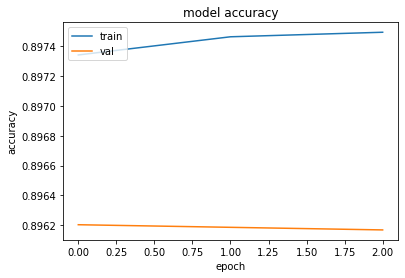

In [27]:
import keras
from matplotlib import pyplot as plt

def plot_fit_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_fit_history(history)

#### model evaluate - rnn

In [28]:
# baseline accuracy
y_test.mean()

0.5

In [29]:
# evaluate the model
loss, accuracy = model_rnn.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

2245/2245 [==============================] - 44s 20ms/step - loss: 0.3194 - accuracy: 0.8974
Accuracy: 89.739734
